In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
df=pd.read_csv("Nutrient_recommendation.csv")
df

,Crop,Temperature,Humidity,Rainfall,Label_N,Label_P,Label_K
0,rice,20.879744,82.002744,202.935536,90,42,43
1,rice,21.770462,80.319644,226.655537,85,58,41
2,rice,23.004459,82.320763,263.964248,60,55,44
3,rice,26.491096,80.158363,242.864034,74,35,40
4,rice,20.130175,81.604873,262.717340,78,42,42
...,...,...,...,...,...,...,...
2195,coffee,26.774637,66.413269,177.774507,107,34,32
2196,coffee,27.417112,56.636362,127.924610,99,15,27
2197,coffee,24.131797,67.225123,173.322839,118,33,30
2198,coffee,26.272418,52.127394,127.175293,117,32,34


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Crop         2200 non-null   object 
 1   Temperature  2200 non-null   float64
 2   Humidity     2200 non-null   float64
 3   Rainfall     2200 non-null   float64
 4   Label_N      2200 non-null   int64  
 5   Label_P      2200 non-null   int64  
 6   Label_K      2200 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 120.4+ KB


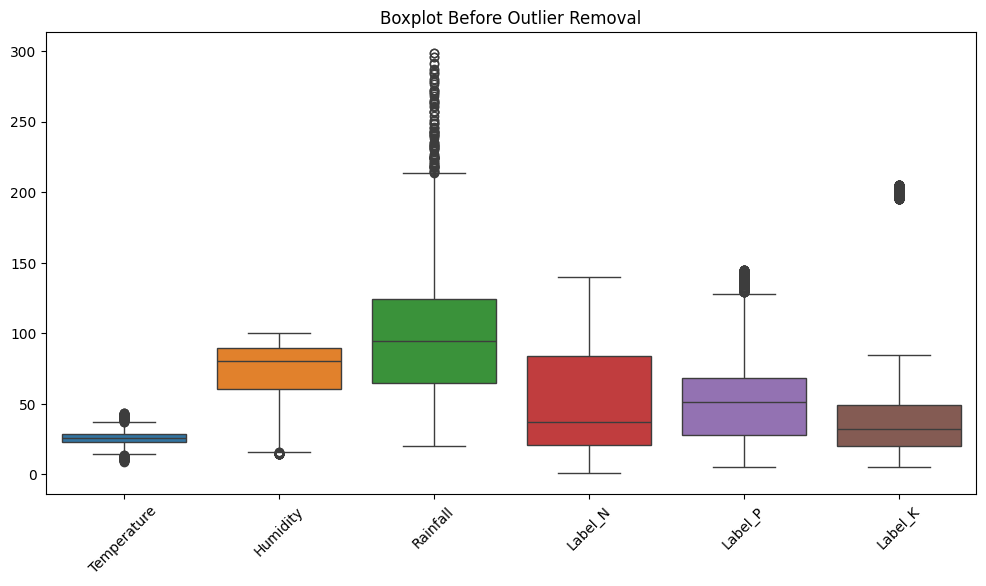

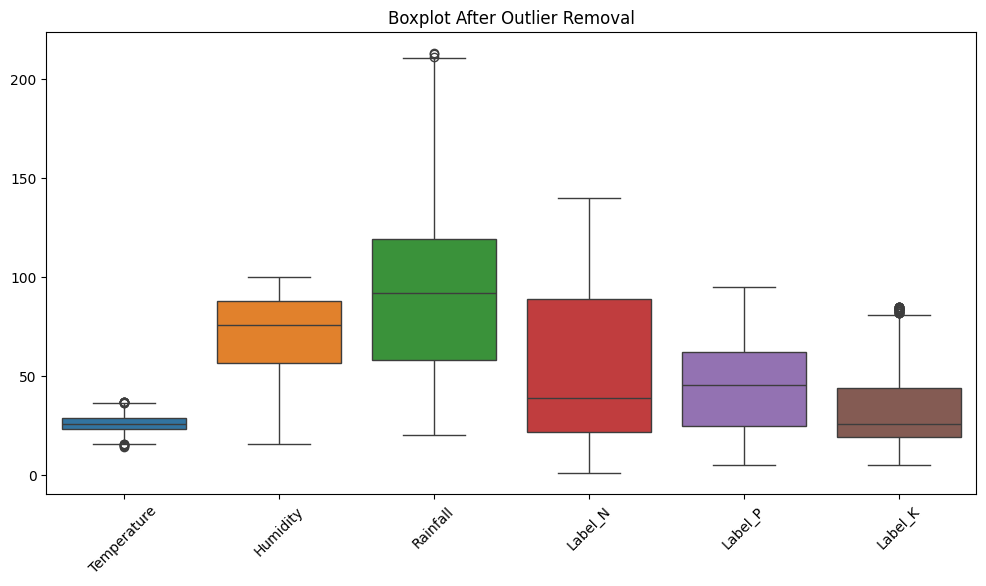

X_train: (1459, 4)
X_test: (365, 4)
y_train: (1459, 3)
y_test: (365, 3)


In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Replace zero 'Label_N' with the median nitrogen value for the same crop
df.loc[:, 'Label_N'] = df.groupby('Crop')['Label_N'].transform(lambda X: X.replace(0, X.median()))

# Impute numerical features
numerical_cols = ['Temperature', 'Humidity', 'Rainfall', 'Label_N', 'Label_P', 'Label_K']
num_imputer = SimpleImputer(strategy='mean')
df.loc[:, numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Impute categorical features
categorical_cols = ['Crop']
cat_imputer = SimpleImputer(strategy='most_frequent')
df.loc[:, categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Prepare combined DataFrame for outlier detection
df_combined = df.copy()

# Identify numerical columns (including Labels)
numerical_cols = df_combined.select_dtypes(include=['number']).columns.tolist()

# Boxplot before outlier removal
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined[numerical_cols])
plt.title("Boxplot Before Outlier Removal")
plt.xticks(rotation=45)
plt.show()

# Compute IQR for outlier detection
Q1 = df_combined[numerical_cols].quantile(0.25)
Q3 = df_combined[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers for all numerical columns
outlier_mask = ~((df_combined[numerical_cols] < lower_bound) | (df_combined[numerical_cols] > upper_bound)).any(axis=1)
df_cleaned = df_combined[outlier_mask]

# Boxplot after outlier removal
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[numerical_cols])
plt.title("Boxplot After Outlier Removal")
plt.xticks(rotation=45)
plt.show()

# Final cleaned X and y using .values
X = df_cleaned.iloc[:, :-3]  # All features
y = df_cleaned.iloc[:, -3:].values  # Last 3 columns: Label_N, Label_P, Label_K

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Check shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


In [80]:
# create mapping of crop(string) to int type
mapping = dict()

# writing the mapping in a file
with open("mapped_crops.csv", "w") as fh:
    fh.write("Crops,Key\n")
    for i, crop in enumerate(np.unique(df[['Crop']]), 1):
        mapping[crop] =  i
        fh.write("%s,%d\n" % (crop, i))
    mapping['NA'] = np.nan
    fh.write("NA,nan")
    
print(mapping)

{'apple': 1, 'banana': 2, 'blackgram': 3, 'chickpea': 4, 'coconut': 5, 'coffee': 6, 'cotton': 7, 'grapes': 8, 'jute': 9, 'kidneybeans': 10, 'lentil': 11, 'maize': 12, 'mango': 13, 'mothbeans': 14, 'mungbean': 15, 'muskmelon': 16, 'orange': 17, 'papaya': 18, 'pigeonpeas': 19, 'pomegranate': 20, 'rice': 21, 'watermelon': 22, 'NA': nan}


In [81]:
# import category encoders
import category_encoders as ce

ordinal_cols_mapping = [{"col": "Crop", "mapping": mapping}, ]

# encode categorical variables with ordinal encoding
encoder = ce.OrdinalEncoder(cols = 'Crop', mapping = ordinal_cols_mapping, return_df = True)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train.head()

,Crop,Temperature,Humidity,Rainfall
957,20,19.861736,86.197409,111.021793
1120,13,28.932702,47.940540,99.983424
255,4,17.574456,16.718266,77.818914
390,10,16.037686,22.331959,130.390080
1344,22,24.067315,81.640753,51.752124


#  Multiple Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Linear Regression MAE: 19.3147
MSE: 608.2005
RMSE: 24.6617
R² Score: 0.1552


In [83]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | R² Score: {r2:.4f}")

# KNN

In [84]:
print("K-Nearest Neighbors Regression:")
knn_model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))
evaluate_model(knn_model, X_train, y_train, X_test, y_test)

K-Nearest Neighbors Regression:
MAE: 7.1996 | MSE: 98.8379 | RMSE: 9.9417 | R² Score: 0.8686


# Decision Tree

In [85]:
print("Decision Tree Regression:")
dt_model = MultiOutputRegressor(DecisionTreeRegressor(random_state=42))
evaluate_model(dt_model, X_train, y_train, X_test, y_test)

Decision Tree Regression:
MAE: 8.7826 | MSE: 148.6461 | RMSE: 12.1921 | R² Score: 0.8047


# SVM

In [100]:
from sklearn.pipeline import make_pipeline
print("Support Vector Regression:")
svr_base = make_pipeline(
    StandardScaler(), 
    SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
)
svr_model = MultiOutputRegressor(svr_base)
evaluate_model(svr_model, X_train, y_train, X_test, y_test)

Support Vector Regression:
MAE: 7.9896 | MSE: 118.5553 | RMSE: 10.8883 | R² Score: 0.8480


# XGBoost

In [87]:
print("XGBoost Regression:")
xgb_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

XGBoost Regression:
MAE: 7.1126 | MSE: 92.4307 | RMSE: 9.6141 | R² Score: 0.8777


# RandomForest

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Basic RF Model
rf = RandomForestRegressor(n_estimators=50, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest:")
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Random Forest:
MAE: 6.585196347031965
MSE: 78.01557342465756
RMSE: 8.832642493877897


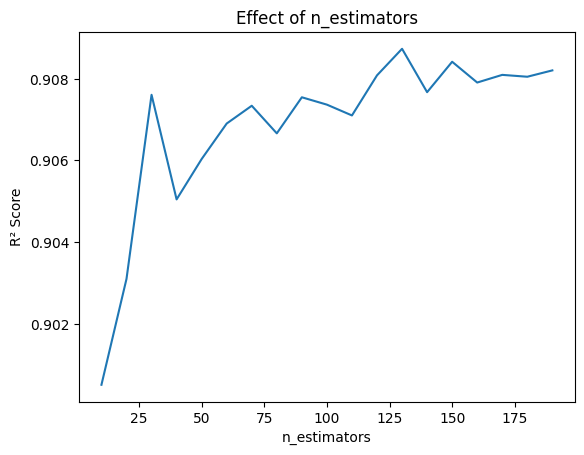

Most consistent model accuracy: 0.908


In [89]:
model = RandomForestRegressor(n_jobs=-1)
estimators = np.arange(10, 200, 10)
scores = []

for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

plt.title("Effect of n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("R² Score")
plt.plot(estimators, scores)
plt.show()

# Most frequent score
scores_arr = [round(s, 3) for s in scores]
unique, counts = np.unique(scores_arr, return_counts=True)

max_count = max(counts)
accuracy = -1
for uni, count in zip(unique, counts):
    if count == max_count:
        accuracy = uni

print("Most consistent model accuracy: %.3f" % accuracy)


# NPKEstimator

In [90]:
import warnings
import numpy as np 
import pandas as pd 
from sklearn import metrics
import category_encoders as ce
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [91]:
class NPKEstimator:
    def __init__(self, data='Nutrient_recommendation.csv'):
        self.df = pd.read_csv(data, header=None)
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        self.renameCol()  # Rename columns
        self.preprocess_data()  # Fix Label_N and remove outliers

    def renameCol(self):
        self.df.columns = ['Crop', 'Temperature', 'Humidity', 'Rainfall', 'Label_N', 'Label_P', 'Label_K']
        self.df.drop(self.df.index[:1], inplace=True)

    def preprocess_data(self):
        """Fix zero values in Label_N and remove outliers."""
        # Convert columns to numeric
        self.df[['Temperature', 'Humidity', 'Rainfall', 'Label_N', 'Label_P', 'Label_K']] = \
            self.df[['Temperature', 'Humidity', 'Rainfall', 'Label_N', 'Label_P', 'Label_K']].apply(pd.to_numeric)

        # Fix zero values in Label_N by replacing them with the median
        median_n = self.df[self.df['Label_N'] > 0]['Label_N'].median()
        self.df['Label_N'] = self.df['Label_N'].replace(0, median_n)

        # Remove outliers using IQR
        for col in ['Label_N', 'Label_P', 'Label_K']:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
    
    def cropMapper(self):
        mapping = dict()
        with open("mapped_crops.csv", "w") as fh:
            fh.write("Crops,Key\n")
            for i, crop in enumerate(np.unique(self.df[['Crop']]), 1):
                mapping[crop] = i
                fh.write("%s,%d\n" % (crop, i))
            mapping['NA'] = np.nan
            fh.write("NA,nan")

        ordinal_cols_mapping = [{"col": "Crop", "mapping": mapping}]
        encoder = ce.OrdinalEncoder(cols='Crop', mapping=ordinal_cols_mapping, return_df=True)
        return mapping, encoder
    
    def estimator(self, crop, temp, humidity, rainfall, y_label):
        mapping, encoder = self.cropMapper()
        self.df = encoder.fit_transform(self.df) 
        X = self.df.drop(['Label_N', 'Label_P', 'Label_K'], axis=1)
        y = self.df[y_label]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.20, random_state=42)

        regressor = RandomForestRegressor(n_estimators=50, random_state=0)
        regressor.fit(self.X_train, self.y_train)

        query = [mapping[crop.strip().lower()], temp, humidity, rainfall]
        y_pred = regressor.predict([query])
        return y_pred

In [92]:
if __name__ == '__main__':
    obj = NPKEstimator()
    crop, temp, humidity, rainfall, y_label = 'rice', 21.94766735, 80.97384195, 213.3560921, 'Label_N'
    res = obj.estimator(crop, temp, humidity, rainfall, y_label)
    print(y_label, ":", res[0])

Label_N : 70.2


In [93]:
if __name__ == '__main__':
    obj = NPKEstimator()
    crop, temp, humidity, rainfall, y_label = 'maize', 25.73044432, 70.74739256, 98.73771338, 'Label_P'
    res = obj.estimator(crop, temp, humidity, rainfall, y_label)
    print(y_label, ":", res[0])

Label_P : 52.18


In [94]:
if __name__ == '__main__':
    obj = NPKEstimator()
    crop, temp, humidity, rainfall, y_label = 'chickpea',17.02498456, 16.98861173, 88.55123143, 'Label_K'
    res = obj.estimator(crop, temp, humidity, rainfall, y_label)
    print(y_label, ":", res[0])

Label_K : 78.28


In [95]:
import requests as rq
import json as js
from time import sleep

In [96]:
class BestTimeToFertilize:
    __BASE_URL = "https://api.weatherbit.io/v2.0/forecast/daily?"
    __API_KEY = "37e27412d34147158e47a8c133278f34"
    
    
    def __init__(self, city_name = 'Bangalore', state_name = 'Karnataka', days = 7):
        self.city_name = '+'.join(city_name.lower().strip().split())
        self.state_name = '+'.join(state_name.lower().strip().split())
        self.country_name = 'IN'
        self.days = days
        self.response = None
        self.response_code = None
        self.weather_data = list()
        
    def api_caller(self):
        try:
            complete_url = "{0}city={1}&state={2}&country={3}&key={4}&days={5}".format(self.__BASE_URL, self.city_name, self.state_name, self.country_name, self.__API_KEY, self.days)
            print(complete_url)
            #while self.response == None:
            self.response = rq.get(complete_url)
            sleep(5)
            self.response_code = self.response.status_code
            return self.response_code
        except Exception as msg:
            print("api_caller():", msg)
            return -1
        
    
    def is_api_call_success(self):
        if self.response_code == 200:
            return True
        elif self.response_code == 204:
            print('Content Not available, error code 204')
        return False
    

    def json_file_bulider(self):
        try:
            json_obj = self.response.json()
            with open('weather_data.json', 'w') as file:
                js.dump(json_obj, file, indent = 1, sort_keys = True)
            print("weather_data.json file build successfully")
        except Exception as msg:
            print("json_bulider():", msg)
            
    
    def best_time_fertilize(self):
        json_obj = self.response.json()
        
        print("City:", json_obj['city_name'], "\n")

        prolonged_precip = 0
        prolonged_prob = 0
        heavy_rain_2d = False
        heavy_rain_chance_2d = 0
        precip_2d = 0
        precip_chance_2d = 0
        
        for i in range(self.days):
            date = json_obj['data'][i]['datetime']
            temp = json_obj['data'][i]['temp']
            rh = json_obj['data'][i]['rh']
            precip = json_obj['data'][i]['precip']
            prob = json_obj['data'][i]['pop']
            w_code = json_obj['data'][i]['weather']['code']
            w_desc = json_obj['data'][i]['weather']['description']
            i_code = json_obj['data'][i]['weather']['icon']
            prolonged_precip += precip
            prolonged_prob += prob

            count_2d = 0
            if i < 2:
                precip_2d += precip
                precip_chance_2d += prob
                if w_code in [202, 233, 502, 521, 522]:
                    heavy_rain_2d = True
                    heavy_rain_chance_2d += prob
                    count_2d += 1
                    heavy_rain_chance_2d //= count_2d
            
            di = {
                  "Date": str(date), 
                  "Temperature": str(temp), 
                  "Relative Humidity": str(rh), 
                  "Rainfall": str(precip), 
                  "Probability of Precipitation": str(prob),
                  "Weather code": str(w_code),
                  "Weather Description": str(w_desc),
                  "Icon code": str(i_code)
                 }
            self.weather_data.append(di)
            
            print("Date:", date)
            print("Temperature:", temp)
            print("Relative Humidity:", rh)
            print("Rainfall:", precip)
            print("Probability of Precipitation:", prob)
            print("Weather code:", w_code, "->", w_desc)
            print()

        prolonged_prob //= self.days
        precip_chance_2d //= 2

        print("-"*80)
        print("The amount of rain for 2 days, counting today:", precip_2d)
        print("Chances of rain for 2 days, counting today:", precip_chance_2d)
        print()

        if heavy_rain_2d:
            print("*"*21, "Warning !!!", "*"*21)
            print("Heavy Rain Chances:", heavy_rain_chance_2d)
            print("Heavy Rainfall puts your fertilizer at risk.")
            print("*"*21, "Warning !!!", "*"*21)

        print("Prolonged Precipitation:", prolonged_precip)
        print("Prolonged Precipitation Probability:", prolonged_prob)
        print()

        if prolonged_precip > 12.7 and prolonged_prob >= 50:
            print("*"*21, "Warning !!!", "*"*21)
            print("Prolonged Rainfall of greater than 12.7 mm puts your fertilizer at risk.")
            print("*"*21, "Warning !!!", "*"*21)

In [97]:
if __name__ == '__main__':
    obj = BestTimeToFertilize('Bhubaneswar', 'Odisha')
    print(obj.api_caller())
    if obj.is_api_call_success():
        obj.best_time_fertilize()
        obj.json_file_bulider()
#         print(obj.weather_data)

https://api.weatherbit.io/v2.0/forecast/daily?city=bhubaneswar&state=odisha&country=IN&key=37e27412d34147158e47a8c133278f34&days=7
200
City: Bhubaneswar 

Date: 2025-04-07
Temperature: 30.1
Relative Humidity: 71
Rainfall: 0.49023438
Probability of Precipitation: 15
Weather code: 801 -> Few clouds

Date: 2025-04-08
Temperature: 29.8
Relative Humidity: 71
Rainfall: 0.05078125
Probability of Precipitation: 20
Weather code: 801 -> Few clouds

Date: 2025-04-09
Temperature: 28.8
Relative Humidity: 71
Rainfall: 0.015625
Probability of Precipitation: 20
Weather code: 801 -> Few clouds

Date: 2025-04-10
Temperature: 28.9
Relative Humidity: 71
Rainfall: 0.22656155
Probability of Precipitation: 20
Weather code: 801 -> Few clouds

Date: 2025-04-11
Temperature: 29.8
Relative Humidity: 70
Rainfall: 0.09504795
Probability of Precipitation: 20
Weather code: 801 -> Few clouds

Date: 2025-04-12
Temperature: 29.4
Relative Humidity: 75
Rainfall: 0.0625
Probability of Precipitation: 20
Weather code: 803 ->